# Path Planning

The path planning of the thymio robot is made using the A* algorithm.

## Initialisation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tdmclient import aw, ClientAsync
from matplotlib import colors
import math
import time

%matplotlib inline

La simulation se fait actuellement avec un fichier test. Toutefois dans le futur l'image sera directement issue du module vision.
Ici nous diminuons la taille de l'image grâce au coefficient reduction_coeff, afin d'obtenir le meilleur compromis entre précision et temps de calcul.

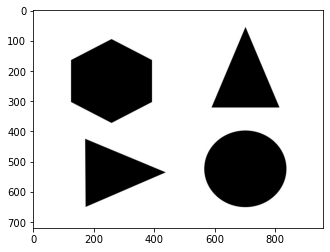

In [2]:
# Data initialisation, currently from a test file
image_path = 'C:/Users/adrie/Downloads/thymio_test2.jpg'

# Ouvrir l'image
img = Image.open(image_path)

# Afficher l'image
plt.imshow(img, cmap='gray')  # Utilisez 'gray' pour les images en niveaux de gris
plt.axis('on')  # Masquer les axes
plt.show()
    
# Convertir l'image en niveaux de gris si elle est en couleur
img = img.convert('L')
    
# Obtenir les données des pixels sous forme de tableau numpy
pixel_data = np.array(img)
    
# Convertir les valeurs des pixels en 0 pour blanc et 1 pour noir
binary_matrix = (pixel_data < 10).astype(int)

max_val_x_init = binary_matrix.shape[0]
max_val_y_init = binary_matrix.shape[1]

reduction_coeff = 20 # tune for speed
max_val_x = int(max_val_x_init / reduction_coeff)
max_val_y = int(max_val_y_init / reduction_coeff)

occupancy_grid = np.zeros((max_val_x, max_val_y), dtype=int)
for i in range (max_val_x):
    for j in range (max_val_y):
        sum_pixels = 0
        for k in range (reduction_coeff): # dans le doute on augmente la distance de sécurité avec obstacle
            sum_pixels = sum_pixels + binary_matrix[int(i * reduction_coeff - reduction_coeff/2 + k)][int(j * reduction_coeff - reduction_coeff/2 + k)]
        if sum_pixels == 0:
            occupancy_grid[i][j] = 0
        else:
            occupancy_grid[i][j] = 1


In [3]:
def create_empty_plot(max_val):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val_x])
    ax.set_xlim([-1,max_val_y])
    ax.grid(True)
    
    return fig, ax

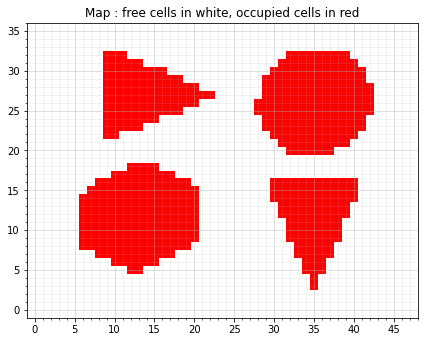

In [4]:
# Printing the grid

fig, ax = create_empty_plot(max_val_y)

cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells

# Displaying the map
ax.imshow(occupancy_grid, cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red");

## A* implementation

In [5]:
def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

In [6]:

def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid, movement_type="4N", max_val_x=max_val_x, max_val_y=max_val_y):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val_y, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]
    current = ([0,0])

    # while there are still elements to investigate
    while openSet != []:
        
        previous = current
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            ROTATION_COST = 1
            
            if(not (current == start)):
                #print(cameFrom)
                vector_prev = ([current[0] - (cameFrom[current])[0], current[1] - (cameFrom[current])[1]]) 
                vector_next = ([neighbor[0] - current[0], neighbor[1] - current[1]]) 
                angle = np.arccos(np.dot(vector_prev, vector_next) / (np.linalg.norm(vector_prev) * np.linalg.norm(vector_next)))
                rotation_cost = angle * ROTATION_COST
            else:
                rotation_cost = 0
            
            
            
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost + rotation_cost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet


elapsed_time :  1.6799888610839844


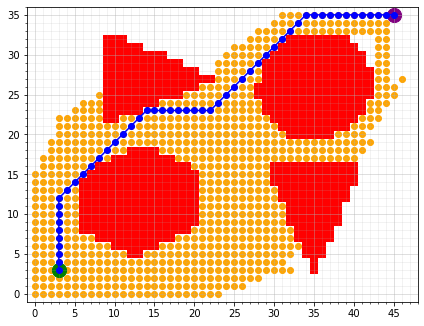

In [7]:
# Define the start and end goal
start = (3,3)
goal = (35,45)



# -----------------------------------------
# DO NOT EDIT THIS PORTION OF CODE - 
# EXECUTION AND PLOTTING OF THE ALGORITHM
# -----------------------------------------
# Record the start time
start_time = time.time()  
    
# List of all coordinates in the grid
x,y = np.mgrid[0:max_val_x:1, 0:max_val_y:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
coords = list([(int(x[0]), int(x[1])) for x in pos])

# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

# Run the A* algorithm
path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, movement_type="8N")
path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("elapsed_time : ", elapsed_time)

# Displaying the map
fig_astar, ax_astar = create_empty_plot(max_val_y)
ax_astar.imshow(occupancy_grid, cmap=cmap)
# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[1], visitedNodes[0], marker="o", color = 'orange');
ax_astar.plot(path[1], path[0], marker="o", color = 'blue');
ax_astar.scatter(start[1], start[0], marker="o", color = 'green', s=200);
ax_astar.scatter(goal[1], goal[0], marker="o", color = 'purple', s=200);

- blanc : libre
- rouge : obstacle
- orange : case explorée
- bleu : chemin le plus court
- vert : départ
- violet : arrivée

Maintenant que nous avons calculé le chemin le plus court, nous appelons des fonctions pour diriger le robot dans la bonne direction.

In [8]:
print(path)

[[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 23 23 23
  23 23 23 23 23 24 25 26 27 28 29 30 31 32 33 34 35 35 35 35 35 35 35 35
  35 35 35 35]
 [ 3  3  3  3  3  3  3  3  3  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
  18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
  42 43 44 45]]
